In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, Input, 
                                   MultiHeadAttention, LayerNormalization,
                                   GlobalAveragePooling1D, TimeDistributed)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                      ReduceLROnPlateau)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===================== Configuration =====================
SEQUENCE_LENGTH = 20       # Number of frames per video clip
IMAGE_HEIGHT = 224         # Increased from 128 for better artifact detection
IMAGE_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 30
MODEL_PATH = "deepfake_detector_improved.h5"

# Enable mixed precision training for 2x speed boost
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# ===================== Data Pipeline =====================
class VideoProcessor:
    @staticmethod
    def extract_frames(video_path, num_frames=SEQUENCE_LENGTH):
        """Extract and preprocess frames from video with error handling"""
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        stride = max(1, total_frames // num_frames)
        
        for i in range(0, min(total_frames, num_frames * stride), stride):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
                frame = frame / 255.0
                frames.append(frame)
        
        cap.release()
        
        # Pad if needed
        while len(frames) < num_frames:
            frames.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
        
        return np.array(frames[:num_frames])
    
    @staticmethod
    def augment_frame(frame):
        """Apply random augmentations to a frame"""
        if np.random.rand() > 0.5:
            frame = tf.image.flip_left_right(frame)
        frame = tf.image.random_brightness(frame, 0.1)
        frame = tf.image.random_contrast(frame, 0.9, 1.1)
        return frame.numpy()

class DeepfakeDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE, augment=False):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(video_paths))
        np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_paths = [self.video_paths[i] for i in batch_indices]
        batch_labels = np.array([self.labels[i] for i in batch_indices])
        
        X = np.zeros((len(batch_indices), SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
        
        for i, path in enumerate(batch_paths):
            frames = VideoProcessor.extract_frames(path)
            if self.augment:
                frames = np.array([VideoProcessor.augment_frame(f) for f in frames])
            X[i] = frames
        
        return X, batch_labels
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# ===================== Model Architecture =====================
def build_advanced_model():
    # EfficientNet backbone for feature extraction
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS),
        pooling='avg'
    )
    base_model.trainable = True  # Fine-tune the backbone
    
    # Frame processing
    frame_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    features = base_model(frame_input)
    frame_model = Model(frame_input, features)
    
    # Temporal processing
    video_input = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    x = TimeDistributed(frame_model)(video_input)
    
    # LSTM + Attention
    x = LSTM(256, return_sequences=True)(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attn)  # Residual connection
    
    # Classification head
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)
    
    model = Model(video_input, output)
    
    model.compile(
        optimizer=Adam(1e-4),
        loss=BinaryFocalCrossentropy(gamma=2.0),
        metrics=['accuracy']
    )
    
    return model

# ===================== Training Utilities =====================
def train_model(train_gen, val_gen):
    model = build_advanced_model()
    
    callbacks = [
        ModelCheckpoint(
            MODEL_PATH,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

def plot_training(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    plt.savefig('training_metrics.png')
    plt.show()

# ===================== Main Execution =====================
if __name__ == "__main__":
    # Load dataset (replace with your paths)
    REAL_DIR = "FF++/real"
    FAKE_DIR = "FF++/fake"
    
    if not (os.path.exists(REAL_DIR) and os.path.exists(FAKE_DIR)):
        print("Error: Dataset directories not found!")
        exit()
    
    # Load and split data
    real_vids = [os.path.join(REAL_DIR, f) for f in os.listdir(REAL_DIR) if f.endswith(('.mp4', '.avi'))]
    fake_vids = [os.path.join(FAKE_DIR, f) for f in os.listdir(FAKE_DIR) if f.endswith(('.mp4', '.avi'))]
    
    videos = real_vids + fake_vids
    labels = [0]*len(real_vids) + [1]*len(fake_vids)
    
    X_train, X_val, y_train, y_val = train_test_split(
        videos, labels, test_size=0.2, stratify=labels, random_state=42
    )
    
    # Create generators
    train_gen = DeepfakeDataGenerator(X_train, y_train, augment=True)
    val_gen = DeepfakeDataGenerator(X_val, y_val)
    
    # Train model
    print("Training improved model...")
    model, history = train_model(train_gen, val_gen)
    plot_training(history)
    
    # Evaluate
    print("Final Evaluation:")
    model = tf.keras.models.load_model(MODEL_PATH)
    results = model.evaluate(val_gen)
    print(f"Validation Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}")

/Users/aditya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Training improved model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/Users/aditya/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


KeyboardInterrupt: 

Loading dataset...
Training set: 160 videos
Testing set: 40 videos
Training model...


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adap

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 202s/step - accuracy: 0.5123 - loss: 0.6954  
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to deepfake_detector_face_cnn_lstm.keras

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to deepfake_detector_face_cnn_lstm.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 2820s 284s/step - accuracy: 0.5106 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2820s 284s/step - accuracy: 0.5106 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 158s/step - accuracy: 0.5531 - loss: 0.6964  
Epoch 2: val_accuracy did not improve from 0.50000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1983s 200s/step - accuracy: 0.5517 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.6947

Epoch 2: val_accuracy did not improve from 0.50000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1983s 200s/step - accuracy: 0.5517 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 3/10
Epoch 3/10

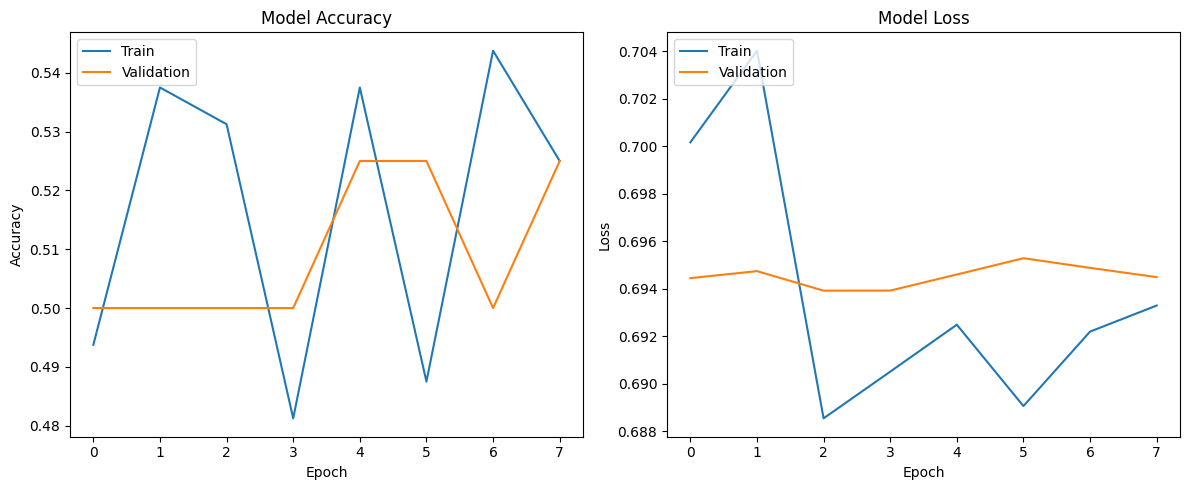

Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 375s 113s/step - accuracy: 0.4609 - loss: 0.6955
3/3 ━━━━━━━━━━━━━━━━━━━━ 375s 113s/step - accuracy: 0.4609 - loss: 0.6955
Test Loss: 0.6939
Test Accuracy: 0.5000

Testing on video.mp4...
Test Loss: 0.6939
Test Accuracy: 0.5000

Testing on video.mp4...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Video: video.mp4
Prediction: FAKE (Confidence: 0.51)
Video: video.mp4
Prediction: FAKE (Confidence: 0.51)


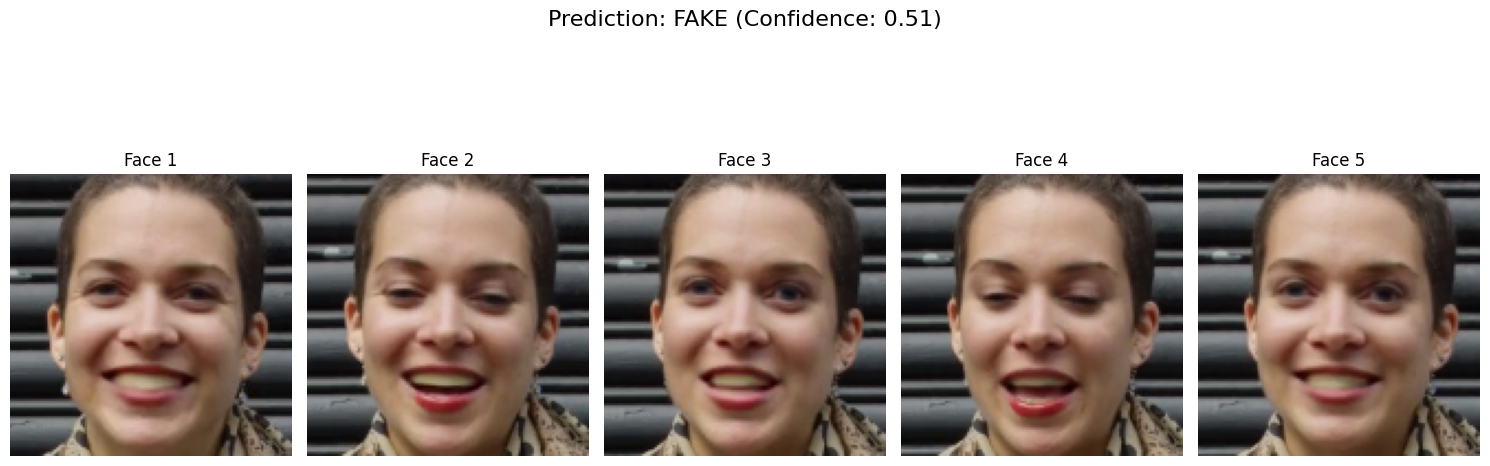

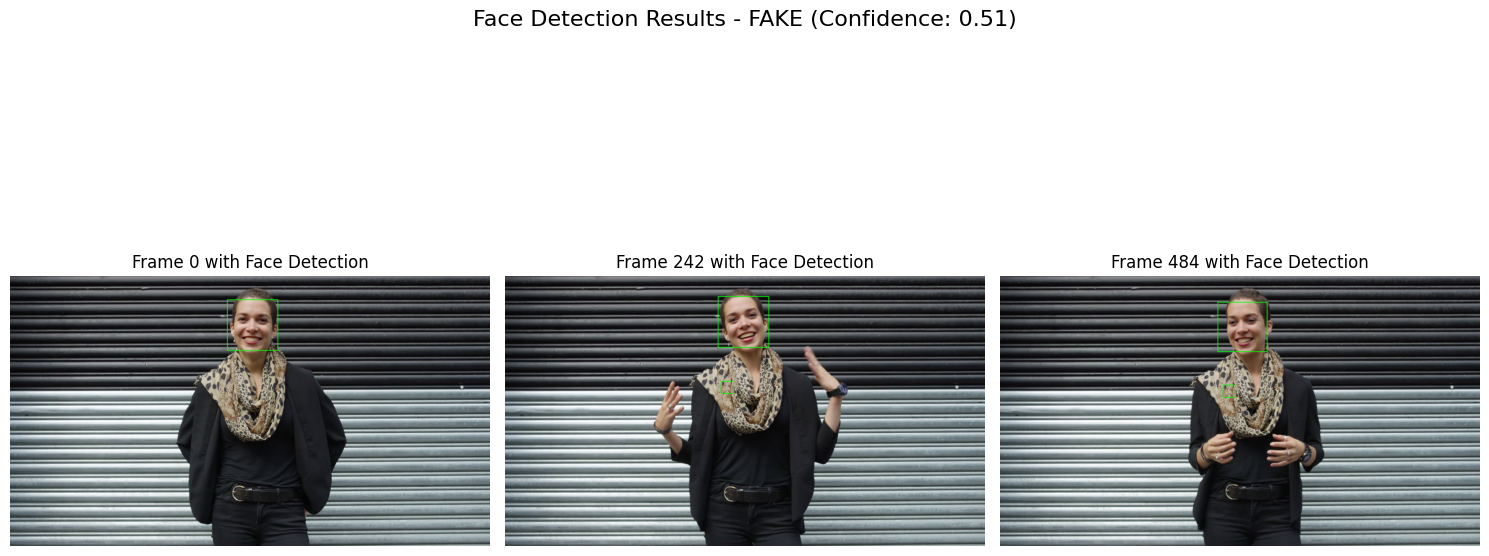

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import TimeDistributed, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
SEQUENCE_LENGTH = 20  # Number of frames per sequence
FACE_HEIGHT = 128  # Height of the extracted face
FACE_WIDTH = 128  # Width of the extracted face
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 10
MODEL_PATH = "deepfake_detector_face_cnn_lstm.keras"

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to extract face from a frame
def extract_face(frame):
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    # If no face is detected, return None
    if len(faces) == 0:
        return None
    
    # Get the largest face
    if len(faces) > 1:
        # Select the largest face based on area (width * height)
        largest_face_idx = np.argmax([w * h for (x, y, w, h) in faces])
        x, y, w, h = faces[largest_face_idx]
    else:
        x, y, w, h = faces[0]
    
    # Add some margin
    margin = int(min(w, h) * 0.1)
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(frame.shape[1] - x, w + 2 * margin)
    h = min(frame.shape[0] - y, h + 2 * margin)
    
    # Extract face region
    face = frame[y:y+h, x:x+w]
    
    # Resize to standard size
    face = cv2.resize(face, (FACE_WIDTH, FACE_HEIGHT))
    
    return face

# Function to extract face sequences from a video
def extract_face_sequence(video_path, num_frames=SEQUENCE_LENGTH):
    face_frames = []
    cap = cv2.VideoCapture(video_path)
    
    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the stride to evenly sample frames
    stride = max(1, total_frames // num_frames)
    
    # Keep track of frames where faces were found
    face_found_count = 0
    
    # Try to get enough frames with faces
    for i in range(0, min(total_frames, num_frames * stride * 2), stride):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Extract face from frame
        face = extract_face(frame)
        
        if face is not None:
            # Normalize pixel values
            face = face / 255.0
            face_frames.append(face)
            face_found_count += 1
            
            # Break if we have enough frames with faces
            if face_found_count >= num_frames:
                break
    
    cap.release()
    
    # If no faces were found, create a sequence of empty frames
    if len(face_frames) == 0:
        print(f"No faces found in {video_path}")
        face_frames = [np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32)] * num_frames
    # Pad if we don't have enough frames with faces
    while len(face_frames) < num_frames:
        if len(face_frames) > 0:
            # Duplicate the last face frame
            face_frames.append(face_frames[-1])
        else:
            # If no faces at all, create empty frames
            face_frames.append(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
        
    # Take only the specified number of frames
    face_frames = face_frames[:num_frames]
    
    return np.array(face_frames)

# Function to load the dataset
def load_dataset(real_dir, fake_dir, test_size=0.2):
    real_videos = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(('.mp4', '.avi'))]
    fake_videos = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(('.mp4', '.avi'))]
    
    # For demonstration - limit dataset size
    real_videos = real_videos[:100]  # Adjust based on your computational resources
    fake_videos = fake_videos[:100]  # Adjust based on your computational resources
    
    videos = real_videos + fake_videos
    labels = [0] * len(real_videos) + [1] * len(fake_videos)  # 0 for real, 1 for fake
    
    # Split into training and testing sets
    train_videos, test_videos, train_labels, test_labels = train_test_split(
        videos, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    return train_videos, test_videos, train_labels, test_labels

# Data generator for batch processing - now using face extraction
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE, seq_length=SEQUENCE_LENGTH):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.indexes = np.arange(len(self.video_paths))
        np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_video_paths = [self.video_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        X = np.zeros((len(batch_indexes), self.seq_length, FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32)
        y = np.array(batch_labels, dtype=np.float32)
        
        for i, video_path in enumerate(batch_video_paths):
            try:
                X[i] = extract_face_sequence(video_path, self.seq_length)
            except Exception as e:
                print(f"Error processing {video_path}: {e}")
                # Fill with zeros if there's an error
                X[i] = np.zeros((self.seq_length, FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32)
        
        return X, y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Build the CNN+LSTM model - adjusted for face input
def build_model():
    # CNN to process each face frame
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(FACE_HEIGHT, FACE_WIDTH, CHANNELS)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten()
    ])
    
    # Full model with LSTM
    model = Sequential([
        TimeDistributed(cnn_model, input_shape=(SEQUENCE_LENGTH, FACE_HEIGHT, FACE_WIDTH, CHANNELS)),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

# Function to train the model
def train_model(train_generator, validation_generator):
    model = build_model()
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        MODEL_PATH,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping]
    )
    
    return model, history

# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig('training_history_face.png')
    plt.show()

# Function to test the model on a video - showing face detection
def test_video(video_path, model):
    # Extract face sequence from the video
    face_frames = extract_face_sequence(video_path)
    # Add batch dimension
    face_frames = np.expand_dims(face_frames, axis=0)
    
    # Make prediction
    prediction = model.predict(face_frames)[0][0]
    
    # Determine if it's real or fake
    label = "FAKE" if prediction > 0.5 else "REAL"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    print(f"Video: {video_path}")
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    
    # Visualize the prediction on some face frames
    plt.figure(figsize=(15, 6))
    
    # Show 5 face frames from the sequence
    for i in range(min(5, len(face_frames[0]))):
        plt.subplot(1, 5, i+1)
        plt.imshow(face_frames[0][i])  # Show normalized face
        plt.title(f"Face {i+1}")
        plt.axis('off')
    
    plt.suptitle(f"Prediction: {label} (Confidence: {confidence:.2f})", fontsize=16)
    plt.tight_layout()
    plt.savefig('face_prediction_visualization.png')
    plt.show()
    
    # Additionally, show face detection on original frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Display 3 frames from the video with face detection
    plt.figure(figsize=(15, 8))
    frame_indexes = [int(total_frames * i / 3) for i in range(3)]
    
    for i, frame_idx in enumerate(frame_indexes):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            # Convert to RGB for display
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Detect face
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 5)
            
            # Draw rectangles around faces
            for (x, y, w, h) in faces:
                cv2.rectangle(frame_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            plt.subplot(1, 3, i+1)
            plt.imshow(frame_rgb)
            plt.title(f"Frame {frame_idx} with Face Detection")
            plt.axis('off')
    
    plt.suptitle(f"Face Detection Results - {label} (Confidence: {confidence:.2f})", fontsize=16)
    plt.tight_layout()
    plt.savefig('face_detection_results.png')
    plt.show()
    
    cap.release()
    
    return prediction, label, confidence

# Main execution
if __name__ == "__main__":
    # Set path to dataset directories
    # Assuming a structure like: dataset/real/ and dataset/fake/
    REAL_DIR = "FF++/real"
    FAKE_DIR = "FF++/fake"
    
    # If you don't have a dataset, you can use FaceForensics++ or DeepFake Detection Challenge dataset
    # For demonstration purposes, let's just print instructions if directories don't exist
    if not (os.path.exists(REAL_DIR) and os.path.exists(FAKE_DIR)):
        print("Dataset directories not found. Please download a deepfake dataset and organize as follows:")
        print("- dataset/real/ (for real videos)")
        print("- dataset/fake/ (for deepfake videos)")
        print("\nSuggested datasets:")
        print("1. FaceForensics++ (https://github.com/ondyari/FaceForensics)")
        print("2. DeepFake Detection Challenge (DFDC)")
        
        # Create dummy directories for demonstration
        os.makedirs(REAL_DIR, exist_ok=True)
        os.makedirs(FAKE_DIR, exist_ok=True)
        
        # Since we don't have real data, we'll create a simple saved model structure
        # so the test function can be demonstrated
        dummy_model = build_model()
        dummy_model.save(MODEL_PATH)
        print(f"\nCreated a dummy model structure at {MODEL_PATH}")
        print("To train a real model, please provide the dataset.")
    else:
        # Load the dataset
        print("Loading dataset...")
        train_videos, test_videos, train_labels, test_labels = load_dataset(REAL_DIR, FAKE_DIR)
        
        print(f"Training set: {len(train_videos)} videos")
        print(f"Testing set: {len(test_videos)} videos")
        
        # Create data generators
        train_generator = DataGenerator(train_videos, train_labels)
        validation_generator = DataGenerator(test_videos, test_labels)
        
        # Train the model
        print("Training model...")
        model, history = train_model(train_generator, validation_generator)
        
        # Plot training history
        plot_history(history)
        
        # Evaluate model on test set
        print("Evaluating model...")
        test_loss, test_accuracy = model.evaluate(validation_generator)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Test on a specific video
    print("\nTesting on video.mp4...")
    TEST_VIDEO = "video.mp4"
    
    if os.path.exists(TEST_VIDEO):
        # Load the trained model
        model = load_model(MODEL_PATH)
        prediction, label, confidence = test_video(TEST_VIDEO, model)
    else:
        print(f"Test video '{TEST_VIDEO}' not found. Please provide a video file to test.")

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
SEQUENCE_LENGTH = 20  # Number of frames per sequence
FACE_HEIGHT = 224  # Height of the extracted face (standard for many pre-trained models)
FACE_WIDTH = 224  # Width of the extracted face
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 20
MODEL_PATH = "deepfake_detector_pretrained_cnn_lstm1.keras"
FEATURE_EXTRACTOR = "mobilenetv2"  # Options: 'resnet50', 'vgg16', 'mobilenetv2'

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to extract face from a frame
def extract_face(frame):
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    # If no face is detected, return None
    if len(faces) == 0:
        return None
    
    # Get the largest face
    if len(faces) > 1:
        # Select the largest face based on area (width * height)
        largest_face_idx = np.argmax([w * h for (x, y, w, h) in faces])
        x, y, w, h = faces[largest_face_idx]
    else:
        x, y, w, h = faces[0]
    
    # Add some margin
    margin = int(min(w, h) * 0.1)
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(frame.shape[1] - x, w + 2 * margin)
    h = min(frame.shape[0] - y, h + 2 * margin)
    
    # Extract face region
    face = frame[y:y+h, x:x+w]
    
    # Resize to standard size
    face = cv2.resize(face, (FACE_WIDTH, FACE_HEIGHT))
    
    return face

# Function to extract face sequences from a video
def extract_face_sequence(video_path, num_frames=SEQUENCE_LENGTH):
    face_frames = []
    cap = cv2.VideoCapture(video_path)
    
    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the stride to evenly sample frames
    stride = max(1, total_frames // num_frames)
    
    # Keep track of frames where faces were found
    face_found_count = 0
    
    # Try to get enough frames with faces
    for i in range(0, min(total_frames, num_frames * stride * 2), stride):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Extract face from frame
        face = extract_face(frame)
        
        if face is not None:
            # Preprocess for the pre-trained model
            face = face.astype(np.float32)
            
            # Apply appropriate preprocessing based on the selected feature extractor
            if FEATURE_EXTRACTOR == 'resnet50':
                face = tf.keras.applications.resnet50.preprocess_input(face)
            elif FEATURE_EXTRACTOR == 'vgg16':
                face = tf.keras.applications.vgg16.preprocess_input(face)
            elif FEATURE_EXTRACTOR == 'mobilenetv2':
                face = tf.keras.applications.mobilenet_v2.preprocess_input(face)
            
            face_frames.append(face)
            face_found_count += 1
            
            # Break if we have enough frames with faces
            if face_found_count >= num_frames:
                break
    
    cap.release()
    
    # If no faces were found, create a sequence of empty frames
    if len(face_frames) == 0:
        print(f"No faces found in {video_path}")
        # Create zero frames with the appropriate preprocessing
        if FEATURE_EXTRACTOR == 'resnet50':
            zero_frame = tf.keras.applications.resnet50.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
        elif FEATURE_EXTRACTOR == 'vgg16':
            zero_frame = tf.keras.applications.vgg16.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
        elif FEATURE_EXTRACTOR == 'mobilenetv2':
            zero_frame = tf.keras.applications.mobilenet_v2.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
        else:
            zero_frame = np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32)
            
        face_frames = [zero_frame] * num_frames
    
    # Pad if we don't have enough frames with faces
    while len(face_frames) < num_frames:
        if len(face_frames) > 0:
            # Duplicate the last face frame
            face_frames.append(face_frames[-1])
        else:
            # If no faces at all, create empty frames with appropriate preprocessing
            if FEATURE_EXTRACTOR == 'resnet50':
                zero_frame = tf.keras.applications.resnet50.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
            elif FEATURE_EXTRACTOR == 'vgg16':
                zero_frame = tf.keras.applications.vgg16.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
            elif FEATURE_EXTRACTOR == 'mobilenetv2':
                zero_frame = tf.keras.applications.mobilenet_v2.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
            else:
                zero_frame = np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32)
                
            face_frames.append(zero_frame)
        
    # Take only the specified number of frames
    face_frames = face_frames[:num_frames]
    
    return np.array(face_frames)

# Function to load the dataset
def load_dataset(real_dir, fake_dir, test_size=0.2):
    real_videos = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(('.mp4', '.avi'))]
    fake_videos = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(('.mp4', '.avi'))]
    
    # For demonstration - limit dataset size
    real_videos = real_videos[:100]  # Adjust based on your computational resources
    fake_videos = fake_videos[:100]  # Adjust based on your computational resources
    
    videos = real_videos + fake_videos
    labels = [0] * len(real_videos) + [1] * len(fake_videos)  # 0 for real, 1 for fake
    
    # Split into training and testing sets
    train_videos, test_videos, train_labels, test_labels = train_test_split(
        videos, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    return train_videos, test_videos, train_labels, test_labels

# Function to get feature extractor based on selected model
def get_feature_extractor():
    if FEATURE_EXTRACTOR == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(FACE_HEIGHT, FACE_WIDTH, CHANNELS))
    elif FEATURE_EXTRACTOR == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(FACE_HEIGHT, FACE_WIDTH, CHANNELS))
    elif FEATURE_EXTRACTOR == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(FACE_HEIGHT, FACE_WIDTH, CHANNELS))
    else:
        raise ValueError(f"Unknown feature extractor: {FEATURE_EXTRACTOR}")
    
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return base_model

# Data generator for batch processing - pre-extracting features to save memory
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE, seq_length=SEQUENCE_LENGTH):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.indexes = np.arange(len(self.video_paths))
        np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_video_paths = [self.video_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        X = np.zeros((len(batch_indexes), self.seq_length, FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32)
        y = np.array(batch_labels, dtype=np.float32)
        
        for i, video_path in enumerate(batch_video_paths):
            try:
                X[i] = extract_face_sequence(video_path, self.seq_length)
            except Exception as e:
                print(f"Error processing {video_path}: {e}")
                # Fill with zeros if there's an error
                if FEATURE_EXTRACTOR == 'resnet50':
                    zero_frame = tf.keras.applications.resnet50.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
                elif FEATURE_EXTRACTOR == 'vgg16':
                    zero_frame = tf.keras.applications.vgg16.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
                elif FEATURE_EXTRACTOR == 'mobilenetv2':
                    zero_frame = tf.keras.applications.mobilenet_v2.preprocess_input(np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32))
                else:
                    zero_frame = np.zeros((FACE_HEIGHT, FACE_WIDTH, CHANNELS), dtype=np.float32)
                    
                X[i] = np.array([zero_frame] * self.seq_length)
        
        return X, y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Build model with pre-trained CNN + LSTM
def build_model():
    # Get the feature extractor based on the selected model
    base_model = get_feature_extractor()
    
    # Create a feature extraction layer
    feature_extractor = Model(
        inputs=base_model.input,
        outputs=GlobalAveragePooling2D()(base_model.output)
    )
    
    # Build the model with TimeDistributed wrapper for sequence processing
    sequence_input = Input(shape=(SEQUENCE_LENGTH, FACE_HEIGHT, FACE_WIDTH, CHANNELS))
    
    # Apply feature extraction to each frame in the sequence
    encoded_sequence = TimeDistributed(feature_extractor)(sequence_input)
    
    # LSTM layers for sequence modeling
    x = LSTM(256, return_sequences=True)(encoded_sequence)
    x = LSTM(128)(x)
    
    # Fully connected layers for classification
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Compile the model
    model = Model(inputs=sequence_input, outputs=outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

# Function to train the model
def train_model(train_generator, validation_generator):
    model = build_model()
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        MODEL_PATH,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping]
    )
    
    return model, history

# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'training_history_pretrained_{FEATURE_EXTRACTOR}.png')
    plt.show()

# Function to visualize the original face (not preprocessed) for better display
def get_original_face_for_display(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    if len(faces) == 0:
        return None
    
    # Get the largest face
    if len(faces) > 1:
        largest_face_idx = np.argmax([w * h for (x, y, w, h) in faces])
        x, y, w, h = faces[largest_face_idx]
    else:
        x, y, w, h = faces[0]
    
    # Add some margin
    margin = int(min(w, h) * 0.1)
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(frame.shape[1] - x, w + 2 * margin)
    h = min(frame.shape[0] - y, h + 2 * margin)
    
    # Extract face region
    face = frame[y:y+h, x:x+w]
    
    # Resize to standard size
    face = cv2.resize(face, (FACE_WIDTH, FACE_HEIGHT))
    
    return face

# Function to test the model on a video
def test_video(video_path, model):
    # Extract face sequence from the video
    face_frames = extract_face_sequence(video_path)
    
    # Add batch dimension
    face_frames_batch = np.expand_dims(face_frames, axis=0)
    
    # Make prediction
    prediction = model.predict(face_frames_batch)[0][0]
    
    # Determine if it's real or fake
    label = "FAKE" if prediction > 0.5 else "REAL"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    print(f"Video: {video_path}")
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    
    # For visualization, let's get the original face frames (not preprocessed)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    stride = max(1, total_frames // SEQUENCE_LENGTH)
    
    display_frames = []
    frame_indexes = []
    
    for i in range(0, min(total_frames, SEQUENCE_LENGTH * stride), stride):
        frame_indexes.append(i)
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face = get_original_face_for_display(frame)
            if face is not None:
                display_frames.append(face)
            if len(display_frames) >= 5:  # Just get 5 frames for display
                break
    
    cap.release()
    
    # Visualize the results
    plt.figure(figsize=(15, 6))
    
    # Show 5 face frames or as many as we have
    for i in range(min(5, len(display_frames))):
        plt.subplot(1, 5, i+1)
        plt.imshow(display_frames[i])
        plt.title(f"Face {i+1}")
        plt.axis('off')
    
    plt.suptitle(f"Prediction: {label} (Confidence: {confidence:.2f})", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'face_prediction_{FEATURE_EXTRACTOR}.png')
    plt.show()
    
    # Show face detection on original frames
    cap = cv2.VideoCapture(video_path)
    
    # Display 3 frames from the video with face detection
    plt.figure(figsize=(15, 8))
    display_indexes = [int(total_frames * i / 3) for i in range(3)]
    
    for i, frame_idx in enumerate(display_indexes):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            # Convert to RGB for display
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Detect face
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 5)
            
            # Draw rectangles around faces
            for (x, y, w, h) in faces:
                cv2.rectangle(frame_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            plt.subplot(1, 3, i+1)
            plt.imshow(frame_rgb)
            plt.title(f"Frame {frame_idx} with Face Detection")
            plt.axis('off')
    
    plt.suptitle(f"Face Detection Results - {label} (Confidence: {confidence:.2f})", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'face_detection_{FEATURE_EXTRACTOR}.png')
    plt.show()
    
    cap.release()
    
    return prediction, label, confidence

# Main execution
if __name__ == "__main__":
    # Print information about the current configuration
    print(f"Using pre-trained {FEATURE_EXTRACTOR.upper()} as feature extractor")
    print(f"Face image size: {FACE_WIDTH}x{FACE_HEIGHT}")
    print(f"Sequence length: {SEQUENCE_LENGTH} frames")
    
    # Set path to dataset directories
    # Assuming a structure like: dataset/real/ and dataset/fake/
    REAL_DIR = "FF++/real"
    FAKE_DIR = "FF++/fake"
    
    # If you don't have a dataset, you can use FaceForensics++ or DeepFake Detection Challenge dataset
    # For demonstration purposes, let's just print instructions if directories don't exist
    if not (os.path.exists(REAL_DIR) and os.path.exists(FAKE_DIR)):
        print("Dataset directories not found. Please download a deepfake dataset and organize as follows:")
        print("- dataset/real/ (for real videos)")
        print("- dataset/fake/ (for deepfake videos)")
        print("\nSuggested datasets:")
        print("1. FaceForensics++ (https://github.com/ondyari/FaceForensics)")
        print("2. DeepFake Detection Challenge (DFDC)")
        
        # Create dummy directories for demonstration
        os.makedirs(REAL_DIR, exist_ok=True)
        os.makedirs(FAKE_DIR, exist_ok=True)
        
        # Since we don't have real data, we'll create a simple saved model structure
        # so the test function can be demonstrated
        dummy_model = build_model()
        dummy_model.save(MODEL_PATH)
        print(f"\nCreated a dummy model structure at {MODEL_PATH}")
        print("To train a real model, please provide the dataset.")
    else:
        # Load the dataset
        print("Loading dataset...")
        train_videos, test_videos, train_labels, test_labels = load_dataset(REAL_DIR, FAKE_DIR)
        
        print(f"Training set: {len(train_videos)} videos")
        print(f"Testing set: {len(test_videos)} videos")
        
        # Create data generators
        train_generator = DataGenerator(train_videos, train_labels)
        validation_generator = DataGenerator(test_videos, test_labels)
        
        # Train the model
        print("Training model...")
        model, history = train_model(train_generator, validation_generator)
        
        # Plot training history
        plot_history(history)
        
        # Evaluate model on test set
        print("Evaluating model...")
        test_loss, test_accuracy = model.evaluate(validation_generator)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Test on a specific video
    print("\nTesting on video.mp4...")
    TEST_VIDEO = "video.mp4"
    
    if os.path.exists(TEST_VIDEO):
        # Load the trained model
        model = load_model(MODEL_PATH)
        prediction, label, confidence = test_video(TEST_VIDEO, model)
    else:
        print(f"Test video '{TEST_VIDEO}' not found. Please provide a video file to test.")

Using pre-trained MOBILENETV2 as feature extractor
Face image size: 224x224
Sequence length: 20 frames
Loading dataset...
Training set: 160 videos
Testing set: 40 videos
Training model...


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 160s/step - accuracy: 0.5245 - loss: 0.6902  